In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.tseries.holiday import USFederalHolidayCalendar
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from torchdiffeq import odeint

from dataflow import df_train, df_test, df_geography, df_product

In [2]:
print(torch.cuda.is_available())      # True nếu có GPU
print(torch.cuda.device_count())      # Số lượng GPU có thể sử dụng
print(torch.cuda.get_device_name(0))  # Tên của GPU

True
1
NVIDIA GeForce RTX 3050 Ti Laptop GPU


In [3]:
# Kết nối tự nhiên giữa các bảng
df_train = df_train.merge(df_geography, on='Zip', how='left').merge(df_product, on='ProductID', how='left')
df_test = df_test.merge(df_geography, on='Zip', how='left').merge(df_product, on='ProductID', how='left')

In [4]:
df_train['Date'] = pd.to_datetime(df_train['Date'])
df_test['Date'] = pd.to_datetime(df_test['Date'])

# Lấy các cột cần thiết cho mô hình
df_model = df_train[['Date', 'Units', 'Revenue']]
df_test = df_test[['Date', 'Units', 'Revenue']]

# Nhóm theo ngày và tính tổng số lượng bán (Units) và doanh thu (Revenue) mỗi ngày
df_train = df_model.groupby('Date').agg({'Units': 'sum', 'Revenue': 'sum'}).reset_index()
df_test = df_test.groupby('Date').agg({'Units': 'sum', 'Revenue': 'sum'}).reset_index()

In [5]:
# Tạo dãy ngày đầy đủ từ ngày nhỏ nhất đến ngày lớn nhất trong dữ liệu
full_date_range = pd.date_range(start=df_train['Date'].min(), end=df_train['Date'].max(), freq='D')

# Đặt cột Date làm index để dễ thao tác
df_train.set_index('Date', inplace=True)

# Reindex DataFrame với dãy ngày đầy đủ. Các ngày thiếu sẽ có giá trị NaN
df_train = df_train.reindex(full_date_range)
df_train.index.name = 'Date'

# Sử dụng nội suy tuyến tính dựa trên thời gian để điền các giá trị thiếu
df_train['Units'] = df_train['Units'].interpolate(method='time')
df_train['Revenue'] = df_train['Revenue'].interpolate(method='time')

# Trong trường hợp giá trị tại đầu hoặc cuối chuỗi vẫn là NaN, sử dụng forward/backward fill
df_train['Units'] = df_train['Units'].ffill().bfill()
df_train['Revenue'] = df_train['Revenue'].ffill().bfill()

# Reset index để đưa Date trở lại làm cột thông thường
df_train = df_train.reset_index()

In [6]:
def add_time_features(df):
    """
    Thêm các đặc trưng thời gian, sử dụng cyclical encoding cho day_of_week và month.
    Giả định df có cột Date dạng datetime.
    """
    df['day_of_week'] = df['Date'].dt.dayofweek  # 0: Thứ Hai, 6: Chủ Nhật
    df['month'] = df['Date'].dt.month             # 1 đến 12

    # Cyclical encoding cho day_of_week
    df['dow_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['dow_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

    # Cyclical encoding cho month
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

    # Các cờ khác
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    cal = USFederalHolidayCalendar()
    holidays = cal.holidays(start=df['Date'].min(), end=df['Date'].max())
    df['is_holiday'] = df['Date'].isin(holidays).astype(int)
    df['is_month_start'] = df['Date'].dt.is_month_start.astype(int)
    df['is_month_end'] = df['Date'].dt.is_month_end.astype(int)
    
    return df

In [7]:
df_train = add_time_features(df_train)
df_test = add_time_features(df_test)

In [8]:
scaler = StandardScaler()
df_train[['Units', 'Revenue']] = scaler.fit_transform(df_train[['Units', 'Revenue']]) 
df_test[['Units', 'Revenue']] = scaler.transform(df_test[['Units', 'Revenue']])

In [9]:
# Hàm bổ sung các đặc trưng lag và rolling statistics cho df
def add_lag_features(df):
    # Giả sử df đã được sắp xếp theo Date và các cột 'Units', 'Revenue' đã được nội suy và chuẩn hóa
    df = df.sort_values('Date').reset_index(drop=True)
    # Rolling 7 ngày
    df['Units_mean_7'] = df['Units'].rolling(window=7, min_periods=1).mean()
    df['Units_std_7']  = df['Units'].rolling(window=7, min_periods=1).std().fillna(0)
    df['Revenue_mean_7'] = df['Revenue'].rolling(window=7, min_periods=1).mean()
    df['Revenue_std_7']  = df['Revenue'].rolling(window=7, min_periods=1).std().fillna(0)
    
    # Rolling 30 ngày
    df['Units_mean_30'] = df['Units'].rolling(window=30, min_periods=1).mean()
    df['Units_std_30']  = df['Units'].rolling(window=30, min_periods=1).std().fillna(0)
    df['Revenue_mean_30'] = df['Revenue'].rolling(window=30, min_periods=1).mean()
    df['Revenue_std_30']  = df['Revenue'].rolling(window=30, min_periods=1).std().fillna(0)
    return df

# Sau khi đã xử lý các bước ban đầu (gộp bảng, nội suy, add_time_features, chuẩn hóa),
# ta bổ sung thêm các đặc trưng lag cho df_train và df_test:
df_train = add_lag_features(df_train)
df_test = add_lag_features(df_test)

In [10]:
class TimeSeriesDataset(Dataset):
    def __init__(self, df, window_size=30):
        """
        Mỗi mẫu gồm:
         - x_seq: chuỗi lịch sử (window_size ngày) với 2 biến liên tục đã chuẩn hóa: Units và Revenue.
         - x_cal: các đặc trưng lịch của ngày dự báo, bao gồm các cột ngoài ['Date', 'Units', 'Revenue'].
         - y: giá trị dự báo của ngày đó (Units, Revenue).
        """
        self.window_size = window_size
        self.df = df.sort_values('Date').reset_index(drop=True)
        # Các cột đặc trưng lịch là tất cả các cột ngoại trừ Date, Units, Revenue
        self.calendar_feature_cols = [col for col in self.df.columns if col not in ['Date', 'Units', 'Revenue']]
        self.seq_cols = ['Units', 'Revenue']
        
    def __len__(self):
        return len(self.df) - self.window_size
    
    def __getitem__(self, idx):
        x_seq = self.df.loc[idx:idx+self.window_size-1, self.seq_cols].values.astype(np.float32)
        x_cal = self.df.loc[idx+self.window_size, self.calendar_feature_cols].values.astype(np.float32)
        y = self.df.loc[idx+self.window_size, ['Units', 'Revenue']].values.astype(np.float32)
        return x_seq, x_cal, y

In [11]:
window_size = 30
batch_size = 64

# Tạo dataset và DataLoader cho train (với validation tách ngẫu nhiên) và test
full_dataset = TimeSeriesDataset(df_train, window_size=window_size)
test_dataset = TimeSeriesDataset(df_test, window_size=window_size)

# Tách tập train và validation (20% validation)
seed = 42
torch.manual_seed(seed)
dataset_length = len(full_dataset)
val_size = int(0.2 * dataset_length)
train_size = dataset_length - val_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(seed))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [12]:
##########################################
# VARIABLE SELECTION NETWORK (cho static features)
##########################################
class VariableSelectionNetwork(nn.Module):
    def __init__(self, input_dim, d_model, dropout=0.1):
        super(VariableSelectionNetwork, self).__init__()
        self.input_dim = input_dim
        self.d_model = d_model
        self.feature_proj = nn.ModuleList([nn.Linear(1, d_model) for _ in range(input_dim)])
        self.variable_weights = nn.Sequential(
            nn.Linear(input_dim, input_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(input_dim, input_dim)
        )
    
    def forward(self, x):
        # x: (batch, input_dim)
        projected = [proj(x[:, i].unsqueeze(1)) for i, proj in enumerate(self.feature_proj)]
        projected = torch.stack(projected, dim=1)  # (batch, input_dim, d_model)
        weights = self.variable_weights(x)         # (batch, input_dim)
        weights = torch.softmax(weights, dim=1)
        weighted_sum = torch.sum(projected * weights.unsqueeze(2), dim=1)  # (batch, d_model)
        return weighted_sum, weights

In [13]:
##########################################
# NHITS BRANCH (inspired by N‑BEATS / N‑HITS)
##########################################
class NHITSBlock(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers, forecast_dim, backcast_dim):
        """
        Mỗi block nhận input vector (flattened time series) có kích thước input_dim = window_size*num_series.
        Xuất ra:
          - backcast: phần “giải thích” của input (shape: [batch, backcast_dim])
          - forecast: dự báo (shape: [batch, forecast_dim])
        """
        super(NHITSBlock, self).__init__()
        layers = []
        for i in range(n_layers):
            layers.append(nn.Linear(input_dim if i==0 else hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
        self.fc = nn.Sequential(*layers)
        self.backcast_layer = nn.Linear(hidden_dim, backcast_dim)
        self.forecast_layer = nn.Linear(hidden_dim, forecast_dim)
    
    def forward(self, x):
        # x: (batch, input_dim)
        h = self.fc(x)
        backcast = self.backcast_layer(h)
        forecast = self.forecast_layer(h)
        return backcast, forecast

class NHITSBranch(nn.Module):
    def __init__(self, window_size, num_series, n_blocks, block_hidden_dim, n_block_layers):
        super(NHITSBranch, self).__init__()
        self.window_size = window_size
        self.num_series = num_series
        self.input_dim = window_size * num_series  # chỉ phần chuỗi thời gian
        self.backcast_dim = self.input_dim
        self.forecast_dim = num_series  # dự báo cho mỗi biến (2 giá trị)
        self.n_blocks = n_blocks
        self.blocks = nn.ModuleList([
            NHITSBlock(self.input_dim, block_hidden_dim, n_block_layers, self.forecast_dim, self.backcast_dim)
            for _ in range(n_blocks)
        ])
    
    def forward(self, x_seq):
        # x_seq: (batch, window_size, num_series)
        batch_size = x_seq.size(0)
        x_flat = x_seq.view(batch_size, -1)  # (batch, window_size*num_series)
        residual = x_flat
        forecast_sum = 0
        for block in self.blocks:
            backcast, forecast = block(residual)
            residual = residual - backcast
            forecast_sum = forecast_sum + forecast
        return forecast_sum  # (batch, num_series)

In [14]:
##########################################
# DEEPAR BRANCH (LSTM-based autoregressive)
##########################################
class DeepARBranch(nn.Module):
    def __init__(self, seq_input_dim, d_model, num_layers, dropout):
        super(DeepARBranch, self).__init__()
        self.lstm = nn.LSTM(seq_input_dim, d_model, num_layers=num_layers, batch_first=True, dropout=dropout)
    
    def forward(self, x_seq):
        # x_seq: (batch, window_size, seq_input_dim)
        output, (hn, cn) = self.lstm(x_seq)  # hn: (num_layers, batch, d_model)
        # Lấy hidden state của layer cuối cùng
        return hn[-1]  # (batch, d_model)

In [15]:
##########################################
# INVERTED TRANSFORMER ENCODER LAYER
##########################################
class InvertedTransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, nhead, expansion=4, dropout=0.1):
        super(InvertedTransformerEncoderLayer, self).__init__()
        self.expanded_dim = d_model * expansion
        # Expand projection
        self.fc1 = nn.Linear(d_model, self.expanded_dim)
        # Multi-head attention operating in expanded space
        self.attn = nn.MultiheadAttention(embed_dim=self.expanded_dim, num_heads=nhead, dropout=dropout, batch_first=True)
        # Project back to d_model
        self.fc2 = nn.Linear(self.expanded_dim, d_model)
        self.dropout = nn.Dropout(dropout)
        self.norm1 = nn.LayerNorm(d_model)
        # Feedforward (optional)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_model * 4),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model * 4, d_model),
            nn.Dropout(dropout)
        )
        self.norm2 = nn.LayerNorm(d_model)
    
    def forward(self, src):
        # src: (batch, seq_len, d_model)
        residual = src
        x = self.fc1(src)  # (batch, seq_len, expanded_dim)
        attn_out, _ = self.attn(x, x, x)  # (batch, seq_len, expanded_dim)
        x = self.fc2(attn_out)  # (batch, seq_len, d_model)
        x = self.dropout(x)
        x = self.norm1(residual + x)
        # Feedforward with residual
        residual2 = x
        x_ff = self.ffn(x)
        x = self.norm2(residual2 + x_ff)
        return x

##########################################
# INVERTED TRANSFORMER BRANCH
##########################################
class InvertedTransformerBranch(nn.Module):
    def __init__(self, seq_input_dim, d_model, nhead, num_layers, dropout=0.1):
        super(InvertedTransformerBranch, self).__init__()
        self.input_proj = nn.Linear(seq_input_dim, d_model)
        self.layers = nn.ModuleList([
            InvertedTransformerEncoderLayer(d_model, nhead, expansion=4, dropout=dropout)
            for _ in range(num_layers)
        ])
    
    def forward(self, x_seq):
        # x_seq: (batch, window_size, seq_input_dim) where seq_input_dim = num_series (2)
        x = self.input_proj(x_seq)  # (batch, window_size, d_model)
        for layer in self.layers:
            x = layer(x)
        # Lấy giá trị của time step cuối cùng
        return x[:, -1, :]  # (batch, d_model)

In [16]:
##########################################
# HYBRID FORECASTING MODEL WITH INVERTED TRANSFORMER
##########################################
class HybridForecastingModel_Inverted(nn.Module):
    def __init__(self, window_size, num_series, static_dim, d_model, nhead, num_layers_transformer,
                 n_blocks_nhits, nhits_hidden_dim, nhits_n_layers, deepar_num_layers, dropout=0.1, output_dim=2):
        super(HybridForecastingModel_Inverted, self).__init__()
        # NHITS Branch
        self.nhits_branch = NHITSBranch(window_size, num_series, n_blocks_nhits, nhits_hidden_dim, nhits_n_layers)
        # Inverted Transformer Branch
        self.inverted_transformer_branch = InvertedTransformerBranch(num_series, d_model, nhead, num_layers_transformer, dropout)
        # DeepAR Branch
        self.deepar_branch = DeepARBranch(num_series, d_model, deepar_num_layers, dropout)
        
        # Fusion các nhánh thời gian: concatenate output của 3 nhánh
        fusion_input_dim = (num_series) + d_model + d_model  # NHITS branch (forecast: (batch, num_series)) + Inverted Transformer + DeepAR (each: (batch, d_model))
        self.time_fusion_fc = nn.Sequential(
            nn.Linear(fusion_input_dim, d_model),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        # Static branch: xử lý qua Variable Selection Network
        self.variable_selection = VariableSelectionNetwork(static_dim, d_model, dropout)
        
        # Fusion cuối cùng qua gating: kết hợp time fusion và static
        self.gate_fc = nn.Sequential(
            nn.Linear(2 * d_model, d_model),
            nn.Sigmoid()
        )
        self.fc_fusion = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        # AR skip: từ giá trị cuối của x_seq (các biến ban đầu)
        self.ar_layer = nn.Linear(num_series, d_model)
        
        # Head cuối cùng: kết hợp fusion và AR để dự báo
        self.final_fc = nn.Sequential(
            nn.Linear(2 * d_model, d_model),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, output_dim)
        )
    
    def forward(self, x_seq, x_cal):
        # x_seq: (batch, window_size, num_series)
        # x_cal: (batch, static_dim)
        nhits_out = self.nhits_branch(x_seq)  # (batch, num_series)
        inverted_trans_out = self.inverted_transformer_branch(x_seq)  # (batch, d_model)
        deepar_out = self.deepar_branch(x_seq)  # (batch, d_model)
        
        # Fusion time: concatenate outputs của 3 nhánh
        time_concat = torch.cat([nhits_out, inverted_trans_out, deepar_out], dim=1)  # (batch, num_series + 2*d_model)
        time_fused = self.time_fusion_fc(time_concat)  # (batch, d_model)
        
        # Xử lý static features
        static_feat, _ = self.variable_selection(x_cal)  # (batch, d_model)
        
        # Fusion qua gating
        fusion_concat = torch.cat([time_fused, static_feat], dim=1)  # (batch, 2*d_model)
        gate = self.gate_fc(fusion_concat)  # (batch, d_model)
        fused = gate * time_fused + (1 - gate) * static_feat  # (batch, d_model)
        fused = self.fc_fusion(fused) + fused  # residual
        
        # AR skip từ giá trị cuối của x_seq
        ar_input = x_seq[:, -1, :]  # (batch, num_series)
        ar_feat = self.ar_layer(ar_input)  # (batch, d_model)
        
        combined_final = torch.cat([fused, ar_feat], dim=1)  # (batch, 2*d_model)
        output = self.final_fc(combined_final)  # (batch, output_dim)
        return output


In [17]:
# Xác định static_dim: số lượng cột ngoại lai
cal_feature_cols = [col for col in df_train.columns if col not in ['Date', 'Units', 'Revenue']]
static_dim = len(cal_feature_cols)
num_series = 2

# Cấu hình mô hình
d_model = 64
nhead = 4
num_layers_transformer = 2
n_blocks_nhits = 3
nhits_hidden_dim = 128
nhits_n_layers = 3
deepar_num_layers = 2
output_dim = 2

In [18]:
model = HybridForecastingModel_Inverted(window_size, num_series, static_dim, d_model, nhead, num_layers_transformer,
                                                  n_blocks_nhits, nhits_hidden_dim, nhits_n_layers, deepar_num_layers,
                                                  dropout=0.1, output_dim=output_dim)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [19]:
# Cấu hình optimizer, loss, scheduler
criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

num_epochs = 100  # Bạn có thể tăng số epoch nếu cần
best_val_loss = float('inf')
train_losses = []
val_losses = []

In [20]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for x_seq, x_cal, y in train_loader:
        x_seq = x_seq.to(device)
        x_cal = x_cal.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        outputs = model(x_seq, x_cal)
        loss = criterion(outputs, y)
        loss.backward()
        
        # Áp dụng gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        running_loss += loss.item() * x_seq.size(0)
    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)
    
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for x_seq, x_cal, y in val_loader:
            x_seq = x_seq.to(device)
            x_cal = x_cal.to(device)
            y = y.to(device)
            outputs = model(x_seq, x_cal)
            loss = criterion(outputs, y)
            running_val_loss += loss.item() * x_seq.size(0)
    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)
    
    scheduler.step(epoch_val_loss)
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")
    
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        checkpoint = {
            'epoch': epoch+1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': epoch_val_loss,
        }
        torch.save(checkpoint, 'models/NBEATS1.pth')
        print(f"Best model updated at epoch {epoch+1} with validation loss {epoch_val_loss:.4f}")

Best model updated at epoch 1 with validation loss 0.1806
Best model updated at epoch 2 with validation loss 0.1422
Best model updated at epoch 3 with validation loss 0.1341
Best model updated at epoch 4 with validation loss 0.1222
Best model updated at epoch 5 with validation loss 0.1155
Best model updated at epoch 6 with validation loss 0.0955
Best model updated at epoch 7 with validation loss 0.0935
Best model updated at epoch 8 with validation loss 0.0813
Best model updated at epoch 9 with validation loss 0.0772
Epoch [10/100], Train Loss: 0.0650, Val Loss: 0.0696
Best model updated at epoch 10 with validation loss 0.0696
Best model updated at epoch 11 with validation loss 0.0662
Best model updated at epoch 13 with validation loss 0.0610
Best model updated at epoch 14 with validation loss 0.0565
Best model updated at epoch 15 with validation loss 0.0536
Best model updated at epoch 19 with validation loss 0.0479
Epoch [20/100], Train Loss: 0.0345, Val Loss: 0.0547
Best model updated

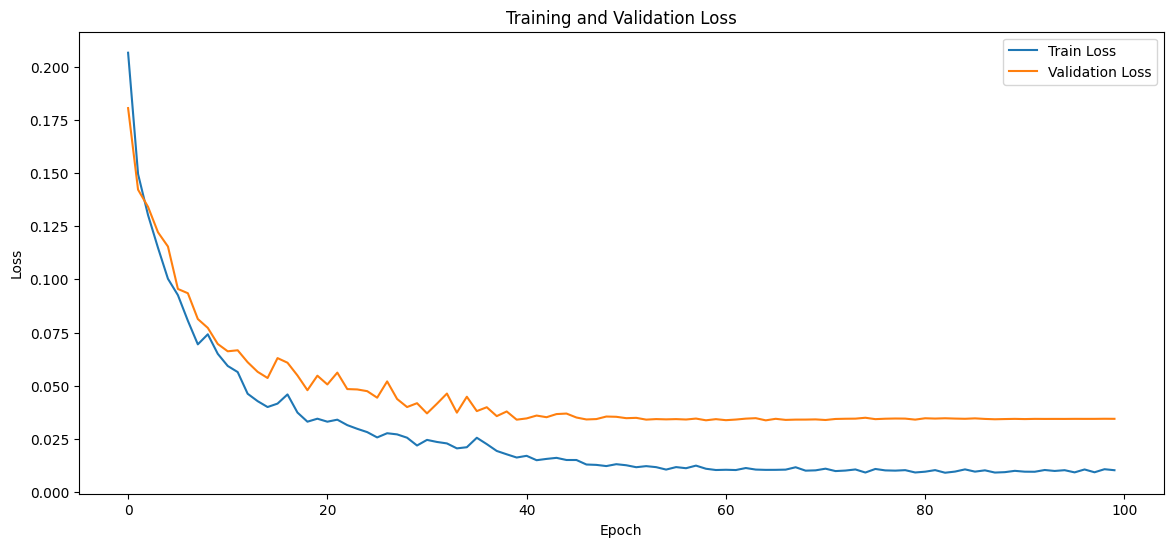

In [21]:
# Vẽ đồ thị loss
plt.figure(figsize=(14, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [22]:
# Load lại mô hình tốt nhất
checkpoint = torch.load('models/NBEATS1.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
print(f"Best model loaded with validation loss: {checkpoint['val_loss']:.4f}")

Best model loaded with validation loss: 0.0337


In [23]:
def get_predictions(loader, model, device):
    model.eval()
    preds = []
    actuals = []
    with torch.no_grad():
        for x_seq, x_cal, y in loader:
            x_seq = x_seq.to(device)
            x_cal = x_cal.to(device)
            outputs = model(x_seq, x_cal)
            preds.append(outputs.cpu().numpy())
            actuals.append(y.numpy())
    preds = np.concatenate(preds, axis=0)
    actuals = np.concatenate(actuals, axis=0)
    return preds, actuals

In [24]:
# Dự báo trên tập train và test
train_preds, train_actuals = get_predictions(train_loader, model, device)
test_preds, test_actuals = get_predictions(test_loader, model, device)

# Inverse transform để đưa về thang đo ban đầu
train_preds_inv = scaler.inverse_transform(train_preds)
train_actuals_inv = scaler.inverse_transform(train_actuals)
test_preds_inv = scaler.inverse_transform(test_preds)
test_actuals_inv = scaler.inverse_transform(test_actuals)

# Tính các chỉ số đánh giá trên tập test
r2 = r2_score(test_actuals_inv, test_preds_inv)
mape = mean_absolute_percentage_error(test_actuals_inv, test_preds_inv)
rmse = np.sqrt(mean_squared_error(test_actuals_inv, test_preds_inv))
print(f"Test R-squared: {r2:.4f}")
print(f"Test MAPE: {mape:.4f}")
print(f"Test RMSE: {rmse:.4f}")

Test R-squared: 0.9365
Test MAPE: 0.5211
Test RMSE: 175339.5781


In [25]:
# Tính các chỉ số riêng cho Units và Revenue
r2_units = r2_score(test_actuals_inv[:, 0], test_preds_inv[:, 0])
mape_units = mean_absolute_percentage_error(test_actuals_inv[:, 0], test_preds_inv[:, 0])
rmse_units = np.sqrt(mean_squared_error(test_actuals_inv[:, 0], test_preds_inv[:, 0]))

print(f"Test Units R-squared: {r2_units:.4f}")
print(f"Test Units MAPE: {mape_units:.4f}")
print(f"Test Units RMSE: {rmse_units:.4f}")

r2_revenue = r2_score(test_actuals_inv[:, 1], test_preds_inv[:, 1])
mape_revenue = mean_absolute_percentage_error(test_actuals_inv[:, 1], test_preds_inv[:, 1])
rmse_revenue = np.sqrt(mean_squared_error(test_actuals_inv[:, 1], test_preds_inv[:, 1]))

print(f"Test Revenue R-squared: {r2_revenue:.4f}")
print(f"Test Revenue MAPE: {mape_revenue:.4f}")
print(f"Test Revenue RMSE: {rmse_revenue:.4f}")

Test Units R-squared: 0.9322
Test Units MAPE: 0.6208
Test Units RMSE: 33.6833
Test Revenue R-squared: 0.9408
Test Revenue MAPE: 0.4214
Test Revenue RMSE: 247967.6406


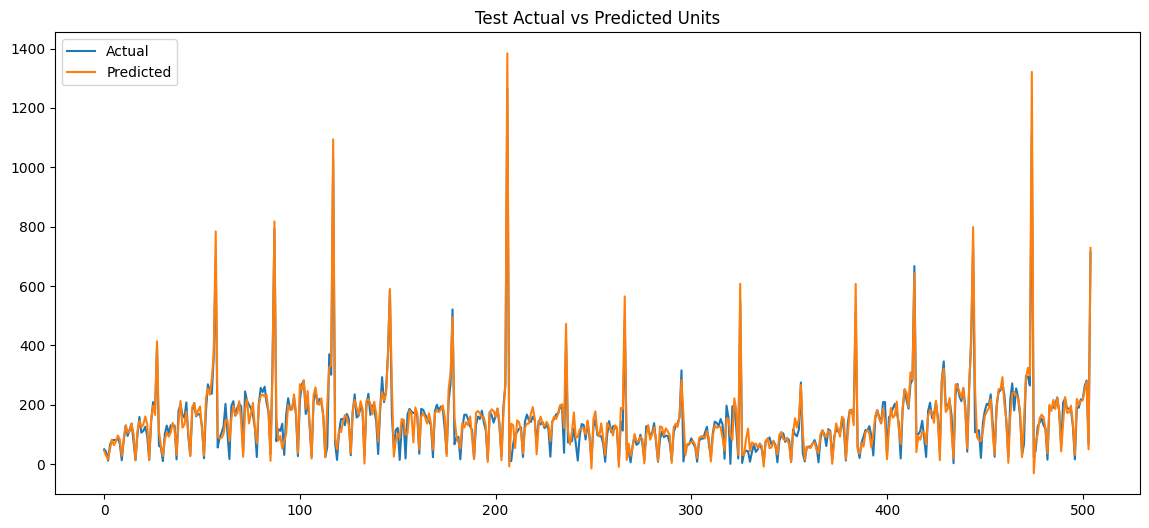

In [26]:
# Vẽ đồ thị dự báo và thực tế đối với Units
plt.figure(figsize=(14, 6))
plt.plot(test_actuals_inv[:, 0], label='Actual')
plt.plot(test_preds_inv[:, 0], label='Predicted')
plt.title('Test Actual vs Predicted Units')
plt.legend()
plt.show()

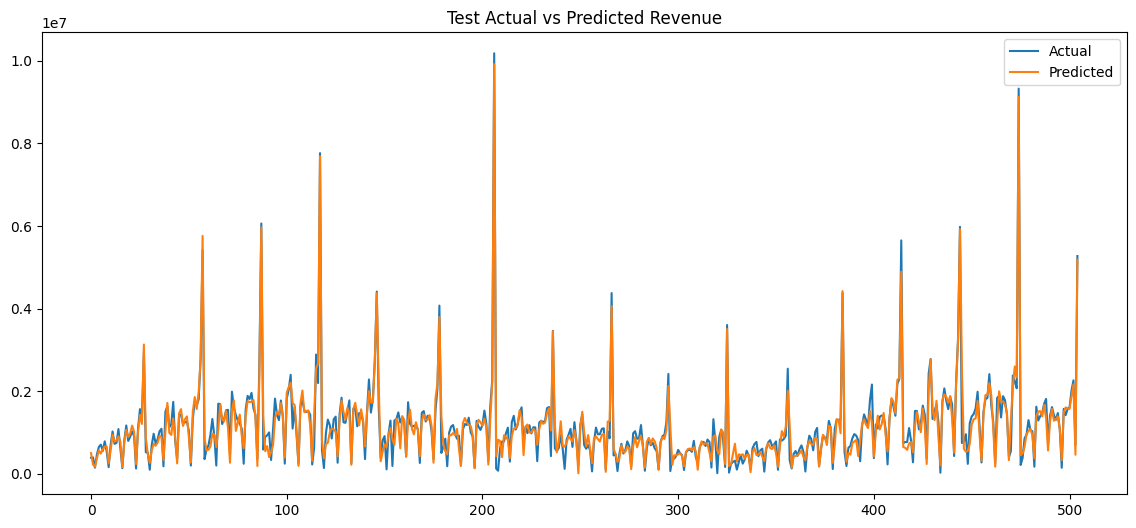

In [27]:
# Vẽ đồ thị dự báo và thực tế đối với Revenue
plt.figure(figsize=(14, 6))
plt.plot(test_actuals_inv[:, 1], label='Actual')
plt.plot(test_preds_inv[:, 1], label='Predicted')
plt.title('Test Actual vs Predicted Revenue')
plt.legend()
plt.show()